In [58]:
from matplotlib import pyplot as plt
from astropy.io import fits
import numpy as np
from scipy import ndimage
import re
import glob
import datetime
import os
import seaborn

from astropy.utils.data import get_file_contents
import astropy.units as u
from astropy.time import Time
from astropy.utils.console import ProgressBar

import pandas as pd

%matplotlib inline
plt.style.use('ggplot')
from IPython.utils import io

In [2]:
# Load the PANOPTES module dir
import sys
sys.path.append('../')

# For development
%load_ext autoreload
%autoreload 2

from panoptes.utils.images import *

INFO:PanoptesLogger:

INFO:PanoptesLogger:********************************************************************************
INFO:PanoptesLogger:

DEBUG:PanoptesLogger:Adding warning logging to: PanError
DEBUG:PanoptesLogger:Adding warning logging to: SerialData
DEBUG:PanoptesLogger:Adding warning logging to: PanStateMachine
DEBUG:PanoptesLogger:Adding warning logging to: AbstractCamera
DEBUG:PanoptesLogger:Adding warning logging to: Observation
DEBUG:PanoptesLogger:Adding warning logging to: Target
DEBUG:PanoptesLogger:Adding warning logging to: Scheduler
DEBUG:PanoptesLogger:Adding warning logging to: Observatory
DEBUG:PanoptesLogger:Adding warning logging to: Panoptes
DEBUG:PanoptesLogger:Adding warning logging to: Messaging
DEBUG:PanoptesLogger:Adding warning logging to: EnvironmentalMonitor
DEBUG:PanoptesLogger:Adding warning logging to: Webcams
DEBUG:PanoptesLogger:Adding warning logging to: PanSensors


In [80]:
dir1 = '/var/panoptes/images/20150920/raw/01_2[0-4][0-9].cr2'

In [69]:
cr2_files = glob.glob(dir1)
cr2_files.sort()
cr2_files

['/var/panoptes/images/20150920/raw/01_200.cr2',
 '/var/panoptes/images/20150920/raw/01_201.cr2',
 '/var/panoptes/images/20150920/raw/01_202.cr2',
 '/var/panoptes/images/20150920/raw/01_203.cr2',
 '/var/panoptes/images/20150920/raw/01_204.cr2',
 '/var/panoptes/images/20150920/raw/01_205.cr2',
 '/var/panoptes/images/20150920/raw/01_206.cr2',
 '/var/panoptes/images/20150920/raw/01_207.cr2',
 '/var/panoptes/images/20150920/raw/01_208.cr2',
 '/var/panoptes/images/20150920/raw/01_209.cr2',
 '/var/panoptes/images/20150920/raw/01_210.cr2',
 '/var/panoptes/images/20150920/raw/01_211.cr2',
 '/var/panoptes/images/20150920/raw/01_212.cr2',
 '/var/panoptes/images/20150920/raw/01_213.cr2',
 '/var/panoptes/images/20150920/raw/01_214.cr2',
 '/var/panoptes/images/20150920/raw/01_215.cr2',
 '/var/panoptes/images/20150920/raw/01_216.cr2',
 '/var/panoptes/images/20150920/raw/01_217.cr2',
 '/var/panoptes/images/20150920/raw/01_218.cr2',
 '/var/panoptes/images/20150920/raw/01_219.cr2',
 '/var/panoptes/imag

In [14]:
pixel_scale = ((206.265) * (18.5 * u.micron) / (85 * u.mm)).cgs * u.arcsecond

In [70]:
def compare(f0, f1):
    pgm_00 = f0.replace('.cr2','.pgm')
    pgm_01 = f1.replace('.cr2','.pgm')    
    
    #if not os.path.exists(pgm_00):
    pgm_00 = cr2_to_pgm(f0)
    #else:
    #    print("Path exists, using {}".format(pgm_00))
                
    #if not os.path.exists(pgm_01):
    pgm_01 = cr2_to_pgm(f1)
    #else:
    #    print("Path exists, using {}".format(pgm_01))                

#    exif_00 = read_exif(pgm_00)
    exif_01 = read_exif(f1)    
    

    raw_data_00 = read_pgm(pgm_00)
    print(raw_data_00)
    raw_data_01 = read_pgm(pgm_01)
    print(raw_data_01)

    x0, y0 = measure_offset(raw_data_00,raw_data_01, box_width=200)
    
    with io.capture_output() as captured:    
        !/var/panoptes/bin/measure_offset $f0 $f1 
        
    x1 = float(get_file_contents('xcent.txt'))
    y1 = float(get_file_contents('ycent.txt'))

#    return ( x0, y0, x1, y1 )
    fmt = '%a %b %d %H:%M:%S %Y'
    t = datetime.datetime.strptime(exif_01.get('Timestamp'), fmt)
    return (x0, y0, x1, y1, t)

In [71]:
    comparison = []

    for i in np.arange(len(cr2_files)):
        if i < len(cr2_files) - 1:
            comparison.append(compare(cr2_files[i], cr2_files[i+1]))

[[2073 2082 2074 ..., 2091 2066 2112]
 [2097 2059 2108 ..., 2070 2099 2067]
 [2077 2112 2074 ..., 2102 2084 2105]
 ..., 
 [2096 2061 2129 ..., 2080 2122 2076]
 [2091 2101 2095 ..., 2112 2063 2117]
 [2088 2084 2117 ..., 2080 2117 2074]]
[[2084 2105 2065 ..., 2089 2066 2102]
 [2107 2077 2103 ..., 2079 2113 2091]
 [2074 2117 2063 ..., 2088 2078 2106]
 ..., 
 [2107 2074 2106 ..., 2084 2094 2090]
 [2076 2100 2062 ..., 2108 2071 2107]
 [2095 2079 2113 ..., 2076 2119 2078]]
[[2084 2105 2065 ..., 2089 2066 2102]
 [2107 2077 2103 ..., 2079 2113 2091]
 [2074 2117 2063 ..., 2088 2078 2106]
 ..., 
 [2107 2074 2106 ..., 2084 2094 2090]
 [2076 2100 2062 ..., 2108 2071 2107]
 [2095 2079 2113 ..., 2076 2119 2078]]
[[2066 2089 2079 ..., 2096 2066 2099]
 [2091 2084 2112 ..., 2080 2100 2082]
 [2074 2107 2072 ..., 2125 2068 2115]
 ..., 
 [2109 2077 2078 ..., 2085 2111 2103]
 [2072 2108 2073 ..., 2120 2084 2097]
 [2084 2059 2094 ..., 2098 2099 2079]]
[[2066 2089 2079 ..., 2096 2066 2099]
 [2091 2084 2112 .

In [72]:
comparison

[(0.29473684210526313,
  -0.23684210526315788,
  0.2181,
  0.477107,
  datetime.datetime(2015, 9, 20, 10, 10, 58)),
 (0.18947368421052632,
  -0.13157894736842105,
  0.185534,
  0.315553,
  datetime.datetime(2015, 9, 20, 10, 13, 16)),
 (-1.0566037735849056,
  0.062893081761006289,
  0.250061,
  -2.04142,
  datetime.datetime(2015, 9, 20, 10, 15, 34)),
 (-0.76165803108808294,
  -0.015544041450777202,
  0.171347,
  -1.27753,
  datetime.datetime(2015, 9, 20, 10, 17, 51)),
 (0.62962962962962965,
  -0.18518518518518517,
  0.123623,
  1.00728,
  datetime.datetime(2015, 9, 20, 10, 20, 10)),
 (-0.72413793103448276,
  -0.10344827586206896,
  0.119082,
  -1.12748,
  datetime.datetime(2015, 9, 20, 10, 22, 27)),
 (-1.4375,
  -0.23214285714285715,
  0.135838,
  -2.40791,
  datetime.datetime(2015, 9, 20, 10, 24, 45)),
 (0.48618784530386738,
  0.055248618784530384,
  0.0550171,
  0.683814,
  datetime.datetime(2015, 9, 20, 10, 27, 3)),
 (0.35028248587570621,
  -0.062146892655367235,
  0.0448144,
  0.479

In [73]:
x0 = [x[0] for x in comparison]
y0 = [x[1]*-1 for x in comparison]
x1 = [x[2] for x in comparison]
y1 = [x[3] for x in comparison]

dates = [x[4] for x in comparison]
dt_index = pd.DatetimeIndex(dates)
dt_index

In [75]:
x0_offset = pd.DataFrame(x0, dt_index)
y0_offset = pd.DataFrame(y0, dt_index)
x1_offset = pd.DataFrame(y1, dt_index)
y1_offset = pd.DataFrame(x1, dt_index)

In [76]:
series = pd.concat([x0_offset, x1_offset, y0_offset, y1_offset], axis=1)
series.index = dt_index
series.columns=["Gee $\Delta{x}$","Guyon $\Delta{x}$","Gee $\Delta{y}$","Guyon $\Delta{y}$"]

In [77]:
series

,Gee $\Delta{x}$,Guyon $\Delta{x}$,Gee $\Delta{y}$,Guyon $\Delta{y}$
2015-09-20 10:10:58,0.294737,0.477107,0.236842,0.218100
2015-09-20 10:13:16,0.189474,0.315553,0.131579,0.185534
2015-09-20 10:15:34,-1.056604,-2.041420,-0.062893,0.250061
2015-09-20 10:17:51,-0.761658,-1.277530,0.015544,0.171347
2015-09-20 10:20:10,0.629630,1.007280,0.185185,0.123623
2015-09-20 10:22:27,-0.724138,-1.127480,0.103448,0.119082
2015-09-20 10:24:45,-1.437500,-2.407910,0.232143,0.135838
2015-09-20 10:27:03,0.486188,0.683814,-0.055249,0.055017
2015-09-20 10:29:20,0.350282,0.479751,0.062147,0.044814
2015-09-20 10:31:39,-1.308333,-2.161410,-0.050000,0.043822


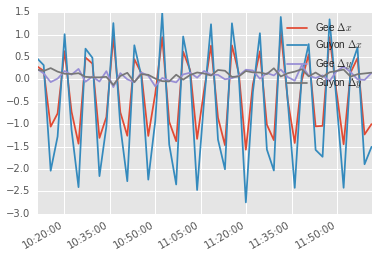

In [78]:
series.plot()
plt.legend(loc=1)